In [67]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [68]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [69]:
NUM_CLASSES = 25

# Dataset reading

In [70]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [71]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [74]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                860       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 25)                275       
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [76]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [77]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
15/15 [==============================] - 0s 10ms/step - loss: 3.2468 - accuracy: 0.0370 - val_loss: 3.1959 - val_accuracy: 0.0815

Epoch 00001: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 2/1000
15/15 [==============================] - 0s 3ms/step - loss: 3.2162 - accuracy: 0.0539 - val_loss: 3.1724 - val_accuracy: 0.0699

Epoch 00002: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 3/1000
15/15 [==============================] - 0s 4ms/step - loss: 3.1867 - accuracy: 0.0494 - val_loss: 3.1483 - val_accuracy: 0.0948

Epoch 00003: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 4/1000
15/15 [==============================] - 0s 4ms/step - loss: 3.1470 - accuracy: 0.0512 - val_loss: 3.1146 - val_accuracy: 0.0882

Epoch 00004: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
Epoch 5/1000
15/15 [==============================] - 0s 4ms/step - loss: 3.1328 - accuracy: 0.0664 - val_l

In [78]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 1ms/step - loss: 0.5163 - accuracy: 0.9484


In [79]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [80]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.9842232e-04 3.7095134e-08 6.3392278e-08 1.5919509e-06 7.7961053e-04
 1.3867139e-03 5.9364280e-05 9.5130390e-01 2.2595564e-03 9.5342935e-12
 3.3944179e-05 2.1832755e-02 4.7620898e-09 2.1099981e-06 1.7766649e-09
 5.3957069e-07 4.3810438e-03 1.0357808e-03 1.6618310e-02 4.4081088e-07
 1.4351147e-05 9.1416128e-05 3.7177770e-13 4.8544875e-12 6.4572736e-11]
7


# Confusion matrix

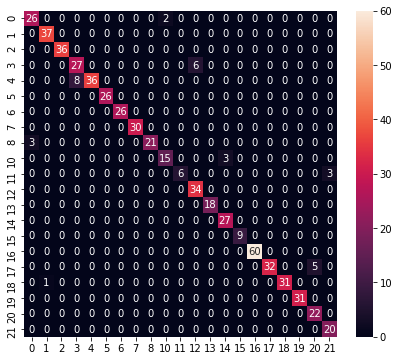

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        28
           1       0.97      1.00      0.99        37
           2       1.00      1.00      1.00        36
           3       0.77      0.82      0.79        33
           4       1.00      0.82      0.90        44
           5       1.00      1.00      1.00        26
           6       1.00      1.00      1.00        26
           7       1.00      1.00      1.00        30
           8       1.00      0.88      0.93        24
          10       0.88      0.83      0.86        18
          11       1.00      0.67      0.80         9
          12       0.85      1.00      0.92        34
          13       1.00      1.00      1.00        18
          14       0.90      1.00      0.95        27
          15       1.00      1.00      1.00         9
          16       1.00      1.00      1.00        60
          17       1.00      0.86      0.93        37
     

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [82]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [83]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\shano\AppData\Local\Temp\tmpj00cw9x5\assets
INFO:tensorflow:Assets written to: C:\Users\shano\AppData\Local\Temp\tmpj00cw9x5\assets


7312

# Inference test

In [84]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [85]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [86]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [87]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 0 ns


In [88]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.9842231e-04 3.7095198e-08 6.3392271e-08 1.5919537e-06 7.7961077e-04
 1.3867144e-03 5.9364382e-05 9.5130378e-01 2.2595553e-03 9.5343100e-12
 3.3944176e-05 2.1832773e-02 4.7620983e-09 2.1100020e-06 1.7766647e-09
 5.3957166e-07 4.3810429e-03 1.0357822e-03 1.6618324e-02 4.4081122e-07
 1.4351173e-05 9.1416296e-05 3.7177908e-13 4.8545053e-12 6.4572847e-11]
7
